In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, Bidirectional, Conv1D, MaxPooling1D
from keras.models import Sequential

# Data Visualization

In [2]:
# Loading dataset and removing indices
df = pd.read_csv('.\DEOK_hourly.csv')
df

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0
...,...,...
57734,2018-01-01 20:00:00,4426.0
57735,2018-01-01 21:00:00,4419.0
57736,2018-01-01 22:00:00,4355.0
57737,2018-01-01 23:00:00,4224.0


In [81]:
# Counting the NaN values in the dataset
df.isna().sum()

Datetime    0
DEOK_MW     0
dtype: int64

In [82]:
# Describe dataset
df.describe()

,DEOK_MW
count,57739.000000
mean,3105.096486
std,599.859026
min,907.000000
25%,2687.000000
50%,3013.000000
75%,3449.000000
max,5445.000000


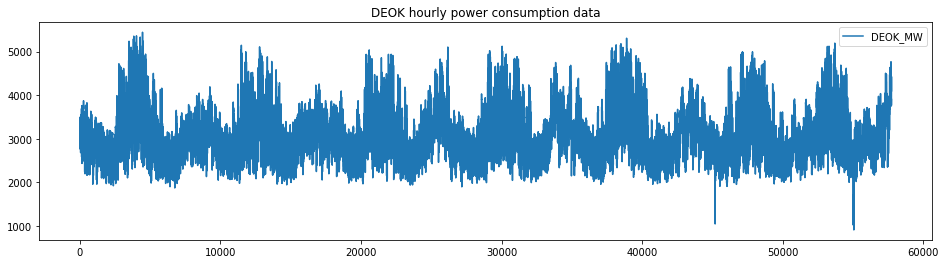

In [83]:
# Plot data
df.plot(figsize=(16,4),legend=True)

plt.title('DEOK hourly power consumption data')

plt.show()

# Data Preparation

In [3]:
# Normalize data

# Define a normalization function
def normalize_data(x):
    scaler = sklearn.preprocessing.MinMaxScaler()
    x = scaler.fit_transform(x.reshape(-1,1))
    return x, scaler

df['DEOK_MW'], scaler = normalize_data(np.array(df['DEOK_MW']))
# df_norm.shape

In [47]:
df['DEOK_MW']

0        0.449097
1        0.432129
2        0.419788
3        0.419788
4        0.430366
           ...   
57734    0.775452
57735    0.773909
57736    0.759806
57737    0.730939
57738    0.703614
Name: DEOK_MW, Length: 57739, dtype: float64

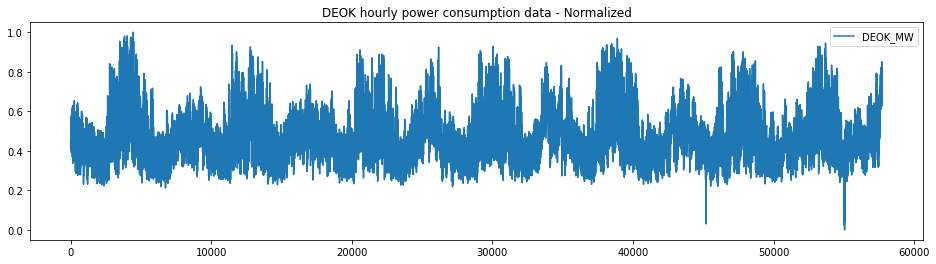

In [61]:
# Plot normalized data

df.plot(figsize=(16,4),legend=True)

plt.title('DEOK hourly power consumption data - Normalized')

plt.show()

In [4]:
from datetime import datetime

def get_from_datetime(date):
    return datetime.strptime(date, '%Y-%m-%d %H:%M:%S')


df['parsed_date'] = df['Datetime'].apply(get_from_datetime) 

In [5]:
def get_hour(date):
    
    return date.hour

df['hour'] = df['parsed_date'].apply(get_hour)


In [6]:
def get_day(date):
    
    return date.day

df['day'] = df['parsed_date'].apply(get_day)


In [7]:
def get_month(date):

    return date.month

df['month'] = df['parsed_date'].apply(get_month)

In [8]:
def get_year(date):

    return date.year

df['year'] = df['parsed_date'].apply(get_year)

In [9]:
df_diff = df.copy()
#add previous sales to the next row
df_diff['DEOK_MW_prev'] = df_diff['DEOK_MW'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['DEOK_MW'] - df_diff['DEOK_MW_prev'])
df_diff

,Datetime,DEOK_MW,parsed_date,hour,day,month,year,DEOK_MW_prev,diff
1,2012-12-31 02:00:00,0.432129,2012-12-31 02:00:00,2,31,12,2012,0.449097,-0.016968
2,2012-12-31 03:00:00,0.419788,2012-12-31 03:00:00,3,31,12,2012,0.432129,-0.012340
3,2012-12-31 04:00:00,0.419788,2012-12-31 04:00:00,4,31,12,2012,0.419788,0.000000
4,2012-12-31 05:00:00,0.430366,2012-12-31 05:00:00,5,31,12,2012,0.419788,0.010577
5,2012-12-31 06:00:00,0.451741,2012-12-31 06:00:00,6,31,12,2012,0.430366,0.021375
...,...,...,...,...,...,...,...,...,...
57734,2018-01-01 20:00:00,0.775452,2018-01-01 20:00:00,20,1,1,2018,0.768180,0.007272
57735,2018-01-01 21:00:00,0.773909,2018-01-01 21:00:00,21,1,1,2018,0.775452,-0.001543
57736,2018-01-01 22:00:00,0.759806,2018-01-01 22:00:00,22,1,1,2018,0.773909,-0.014103
57737,2018-01-01 23:00:00,0.730939,2018-01-01 23:00:00,23,1,1,2018,0.759806,-0.028867


In [10]:
df_supervised = df_diff.drop(['DEOK_MW_prev'],axis=1)
for inc in range(1,23):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised  

,Datetime,DEOK_MW,parsed_date,hour,day,month,year,diff,lag_1,lag_2,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22
0,2013-01-01 00:00:00,0.433892,2013-01-01 00:00:00,0,1,1,2013,-0.022918,-0.031732,-0.026003,...,0.009255,0.016307,0.002204,0.024240,0.025342,0.021375,0.010577,0.000000,-0.012340,-0.016968
1,2012-12-30 01:00:00,0.450639,2012-12-30 01:00:00,1,30,12,2012,0.016747,-0.022918,-0.031732,...,0.001763,0.009255,0.016307,0.002204,0.024240,0.025342,0.021375,0.010577,0.000000,-0.012340
2,2012-12-30 02:00:00,0.423314,2012-12-30 02:00:00,2,30,12,2012,-0.027325,0.016747,-0.022918,...,-0.007933,0.001763,0.009255,0.016307,0.002204,0.024240,0.025342,0.021375,0.010577,0.000000
3,2012-12-30 03:00:00,0.414720,2012-12-30 03:00:00,3,30,12,2012,-0.008594,-0.027325,0.016747,...,-0.008153,-0.007933,0.001763,0.009255,0.016307,0.002204,0.024240,0.025342,0.021375,0.010577
4,2012-12-30 04:00:00,0.408550,2012-12-30 04:00:00,4,30,12,2012,-0.006170,-0.008594,-0.027325,...,-0.001983,-0.008153,-0.007933,0.001763,0.009255,0.016307,0.002204,0.024240,0.025342,0.021375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57711,2018-01-01 20:00:00,0.775452,2018-01-01 20:00:00,20,1,1,2018,0.007272,0.042530,0.069414,...,0.015866,0.011900,0.008594,-0.000881,-0.005509,-0.003526,-0.071397,-0.034817,-0.035699,-0.018070
57712,2018-01-01 21:00:00,0.773909,2018-01-01 21:00:00,21,1,1,2018,-0.001543,0.007272,0.042530,...,0.017188,0.015866,0.011900,0.008594,-0.000881,-0.005509,-0.003526,-0.071397,-0.034817,-0.035699
57713,2018-01-01 22:00:00,0.759806,2018-01-01 22:00:00,22,1,1,2018,-0.014103,-0.001543,0.007272,...,-0.003526,0.017188,0.015866,0.011900,0.008594,-0.000881,-0.005509,-0.003526,-0.071397,-0.034817
57714,2018-01-01 23:00:00,0.730939,2018-01-01 23:00:00,23,1,1,2018,-0.028867,-0.014103,-0.001543,...,-0.006170,-0.003526,0.017188,0.015866,0.011900,0.008594,-0.000881,-0.005509,-0.003526,-0.071397


In [130]:
from sklearn.model_selection import train_test_split

# Define predictors and target variable
X = np.array(df_supervised.loc[:, 'diff':'lag_22'])
y = np.array(df_supervised['DEOK_MW'])
X = X.astype('float')

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

X_test.shape

(46172, 23)
(46172,)


(11544, 23)

In [12]:
X

array([[-0.02291758, -0.03173204, -0.02600264, ...,  0.        ,
        -0.01234024, -0.01696783],
       [ 0.01674747, -0.02291758, -0.03173204, ...,  0.01057735,
         0.        , -0.01234024],
       [-0.02732481,  0.01674747, -0.02291758, ...,  0.02137506,
         0.01057735,  0.        ],
       ...,
       [-0.01410313, -0.00154253,  0.00727193, ..., -0.00352578,
        -0.07139709, -0.0348171 ],
       [-0.02886734, -0.01410313, -0.00154253, ..., -0.00550903,
        -0.00352578, -0.07139709],
       [-0.02732481, -0.02886734, -0.01410313, ..., -0.00088145,
        -0.00550903, -0.00352578]])

In [71]:
X.shape

(57716, 23)

In [131]:
# Preparing the shape of train sets
X_train = X_train.reshape(46172, 23, 1)
print(X_train.shape)
y_train = y_train.reshape(46172, 1)
print(y_train.shape)

# Preparing the shape of test sets
X_test = X_test.reshape(11544, 23, 1)
print(X_test.shape)
y_test = y_test.reshape(11544, 1)
print(y_test.shape)

X = X.reshape(57716, 23, 1)
print(X.shape)
y = y.reshape(57716, 1)
print(y.shape)

(46172, 23, 1)
(46172, 1)
(11544, 23, 1)
(11544, 1)
(57716, 23, 1)
(57716, 1)


In [195]:
df_supervised.to_csv('preprocessed_data.csv')

## LSTM Model (with hyperparameter tuning)

In [14]:
import keras_tuner as kt
from tensorflow import keras

In [15]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(
      hp.Choice('units', [64, 128, 256]),
      recurrent_activation='sigmoid',use_bias=True,dropout = hp.Choice('dropout', [0.1, 0.2, 0.3, 0.4]), go_backwards=True))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='MSE')
    return model

In [16]:
tuner = kt.RandomSearch(build_model,objective='val_loss',max_trials=10)

In [17]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 08m 53s]
val_loss: 0.003956065513193607

Best val_loss So Far: 0.003956065513193607
Total elapsed time: 00h 54m 07s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_model.build(input_shape=(None,23,1))

In [19]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [20]:
y_predicted = best_model.predict(X)
y_test_predicted = best_model.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

81469.03227856109

In [106]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

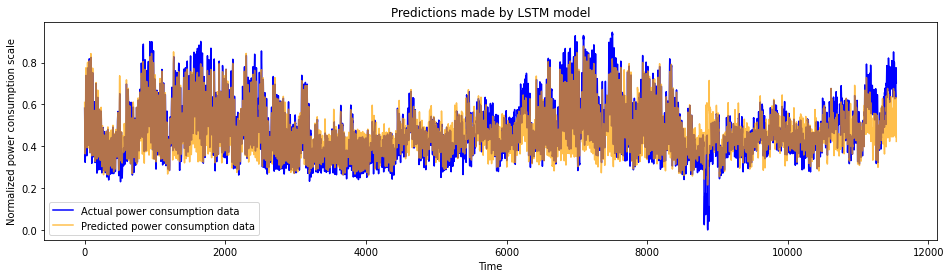

In [64]:
plot_predictions(y_test, y_test_predicted, "Predictions made by LSTM model")

In [25]:
best_model.save('saved_models/lstm')

INFO:tensorflow:Assets written to: saved_models/lstm\assets


INFO:tensorflow:Assets written to: saved_models/lstm\assets


## Bidirectional LSTM Model (with hyperparameter tuning)

In [48]:
import keras_tuner as kt
from tensorflow import keras

In [49]:
def build_model_bidirectional(hp):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(hp.Choice('units', [64, 128, 256]), return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Choice('units', [64, 128, 256]),recurrent_activation='sigmoid',use_bias=True,dropout = hp.Choice('dropout', [0.1, 0.2, 0.3, 0.4]), go_backwards=True)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='MSE')
    return model

In [51]:
tuner = kt.RandomSearch(build_model_bidirectional,objective='val_loss',max_trials=10)

In [52]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 16m 36s]
val_loss: 0.004056491423398256

Best val_loss So Far: 0.003489595837891102
Total elapsed time: 04h 06m 06s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [53]:
best_model.build(input_shape=(None,23,1))

In [54]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 23, 512)          528384    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 2,103,809
Trainable params: 2,103,809
Non-trainable params: 0
_________________________________________________________________


In [55]:
y_predicted = best_model.predict(X)
y_test_predicted = best_model.predict(X_test)

In [56]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

71862.78261948963

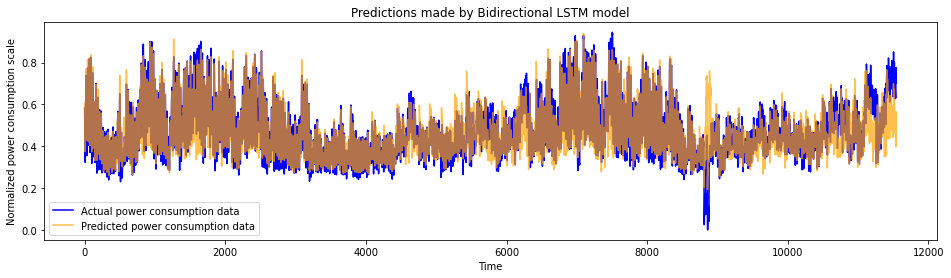

In [133]:
plot_predictions(y_test, y_test_predicted, "Predictions made by Bidirectional LSTM model")

In [58]:
best_model.save('saved_models/bidirectional-lstm')

INFO:tensorflow:Assets written to: saved_models/bidirectional-lstm\assets


INFO:tensorflow:Assets written to: saved_models/bidirectional-lstm\assets


## CNN - LSTM Model (with hyperparameter tuning)

In [27]:
def build_model_cnn_lstm(hp):
    cnn_lstm = Sequential([
    Conv1D(hp.Choice('filters', [16, 32, 64]), hp.Choice('kernel_size', [2, 8, 16]), activation='relu'),
    MaxPooling1D(pool_size=1,strides=2,padding='valid'),
    LSTM(hp.Choice('units', [64, 128, 256]),recurrent_activation='sigmoid',use_bias=True,dropout = hp.Choice('dropout', [0.1, 0.2, 0.3, 0.4]), go_backwards=True),
    Dense(4, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])
    cnn_lstm.compile(optimizer = 'adam', loss='MSE')
    return cnn_lstm

In [30]:
tuner = kt.RandomSearch(build_model_cnn_lstm,objective='val_loss',max_trials=12)

In [31]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 12 Complete [00h 01m 20s]
val_loss: 0.0035006911493837833

Best val_loss So Far: 0.0034943795762956142
Total elapsed time: 00h 30m 45s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [32]:
best_model.build(input_shape=(None,23,1))

In [33]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 32)            96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 297,065
Trainable params: 297,065
Non-trainable params: 0
__________________________________________________

In [34]:
y_predicted = best_model.predict(X)
y_test_predicted = best_model.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

71961.33148443447

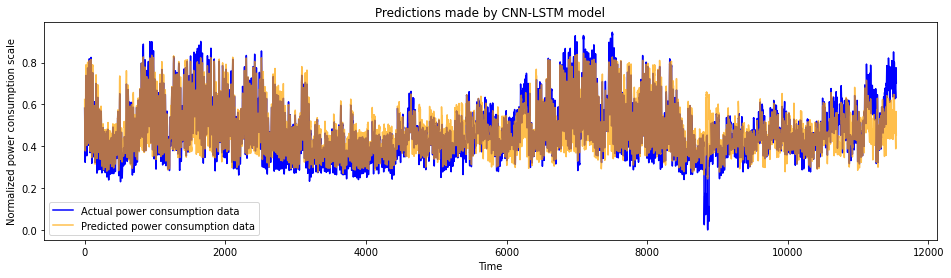

In [36]:
plot_predictions(y_test, y_test_predicted, "Predictions made by CNN-LSTM model")

In [183]:
best_model.save('saved_models/cnn_lstm')

INFO:tensorflow:Assets written to: saved_models/cnn_lstm\assets


INFO:tensorflow:Assets written to: saved_models/cnn_lstm\assets


## SVM

In [125]:
X = np.array(df_supervised.loc[:, 'diff':'lag_22'])
y = np.array(df_supervised['DEOK_MW'])
X = X.astype('float')

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

X_test.shape

(46172, 23)
(46172,)


(11544, 23)

In [74]:
from sklearn.svm import SVR


clf = SVR()
clf.fit(X_train, y_train)


y_test_predicted = clf.predict(X_test)
y_predicted = clf.predict(X)

In [77]:
y_predicted = np.array([y_predicted])
y_test_predicted = np.array([y_test_predicted])
y = np.array([y])
y_test = np.array([y_test])

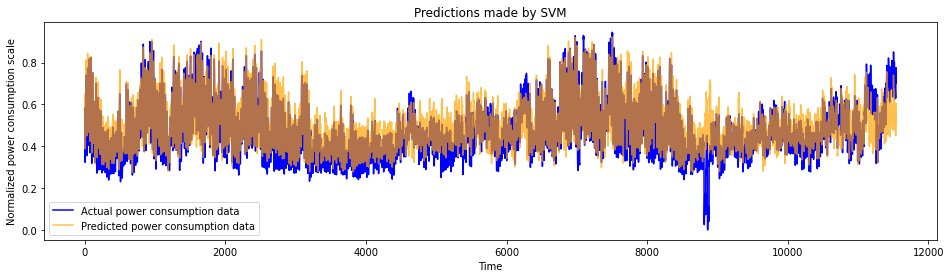

In [75]:
plot_predictions(y_test, y_test_predicted, "Predictions made by SVM")

In [78]:
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

87769.11935965794

## Xgboost

In [80]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
model = XGBRegressor(n_estimators=1000, max_depth=5, eta=0.1)

In [109]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [124]:
y_test_predicted = model.predict(X_test)
y_predicted = model.predict(X)

In [85]:
y_test_predicted.shape

(11544,)

In [126]:
y_predicted = np.array([y_predicted])
y_test_predicted = np.array([y_test_predicted])
y_test = np.array([y_test])

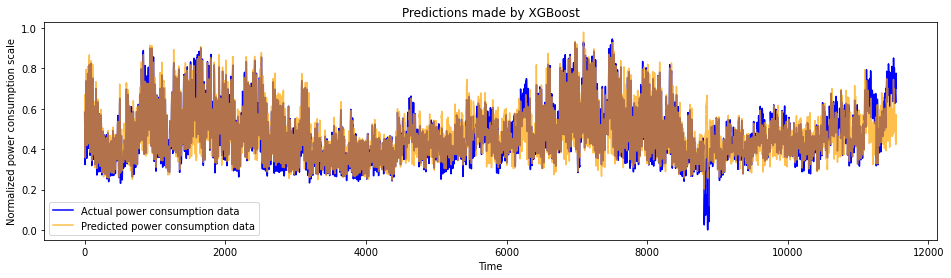

In [111]:
plot_predictions(y_test, y_test_predicted, "Predictions made by XGBoost")

In [127]:
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

57417.17825081395

## AutoML Part

In [8]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [4]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [5]:
#For Windows :
#df = pd.read_csv('.\preprocessed_data.csv')

#For Linux :

df = pd.read_csv('./preprocessed_data.csv')
df = df.drop(['Unnamed: 0', 'Datetime', 'parsed_date', 'hour', 'day', 'month', 'year'],axis=1)

In [6]:
# Autos o kodikas einai gia na pareis ton scaler kai na to trexeis thn invert_transform tou scaler gia to kanoniko mse
#For Windows :
#df_not_normalised = pd.read_csv('.\DEOK_hourly.csv')
#For Linux :
df_not_normalised = pd.read_csv('./DEOK_hourly.csv')

def normalize_data(x):
    scaler = sklearn.preprocessing.MinMaxScaler()
    x = scaler.fit_transform(x.reshape(-1,1))
    return x, scaler

df_not_normalised['DEOK_MW'], scaler = normalize_data(np.array(df_not_normalised['DEOK_MW']))

In [9]:
X = np.array(df.loc[:, 'diff':'lag_22'])
y = np.array(df['DEOK_MW'])
X = X.astype('float')

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

X_test.shape

(46172, 23)
(46172,)


(11544, 23)

In [45]:
X.shape

(57716, 23)

In [10]:
import autosklearn.regression as autoreg
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [11]:
automl = autoreg.AutoSklearnRegressor( \
    time_left_for_this_task=240,\
    per_run_time_limit=60,\
    tmp_folder='./tmp/autosklearn_regression_example_tmp',\
)

automl.fit(X_train, y_train)

/home/stack/miniconda3/envs/tf/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/stack/miniconda3/envs/tf/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnRegressor(per_run_time_limit=60, time_left_for_this_task=240,
                     tmp_folder='./tmp/autosklearn_regression_example_tmp')

In [12]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
6            1             0.88  gradient_boosting  0.140368  11.861833
4            2             0.12     ard_regression  0.237577  26.405528


In [13]:
print(automl.show_models())

{6: {'model_id': 6, 'rank': 1, 'cost': 0.14036845242156715, 'ensemble_weight': 0.88, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f2b3f3b6820>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f2b3e782340>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f2b3e7a1c70>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=2.208787572338781e-05,
                              learning_rate=0.036087332404571744, max_iter=512,
                              max_leaf_nodes=64, min_samples_leaf=3,
                              n_iter_no_change=18, random_state=1,
                              validation_fraction=None, warm_start=True)}, 4: {'model_id': 4, 'rank': 2, 'cost': 0.23757658441899743, 'ensemble_weight': 0.12, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoi

In [14]:
y_test_predicted = automl.predict(X_test)
y_predicted = automl.predict(X)

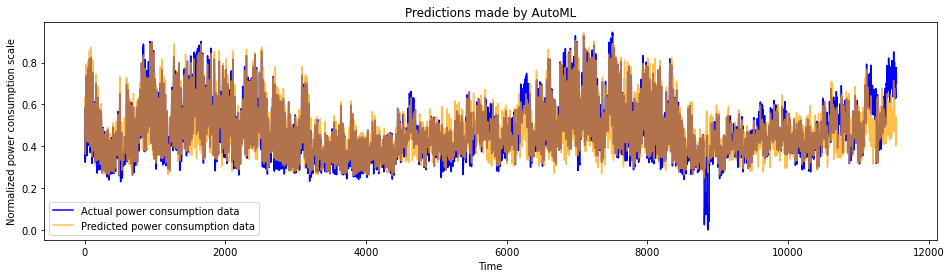

In [15]:
plot_predictions(y_test, y_test_predicted, "Predictions made by AutoML")

In [16]:
y_test_predicted = np.array([y_test_predicted])
y_test = np.array([y_test])

In [17]:
MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_predicted))  # first 2 steps, combined
MSE

60505.15570071318

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

In [25]:
mse_values = np.array([57417.1782,60505.1557,71862.7826,71961.3314,81469.0322,87769.1193])
model_names = [
    "XGBoost","AutoML","Bidirectional-LSTM","CNN-LSTM","LSTM","SVM" 
    ]
y = [i * 0.9 for i in range(len(model_names))]

In [49]:
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

<BarContainer object of 6 artists>

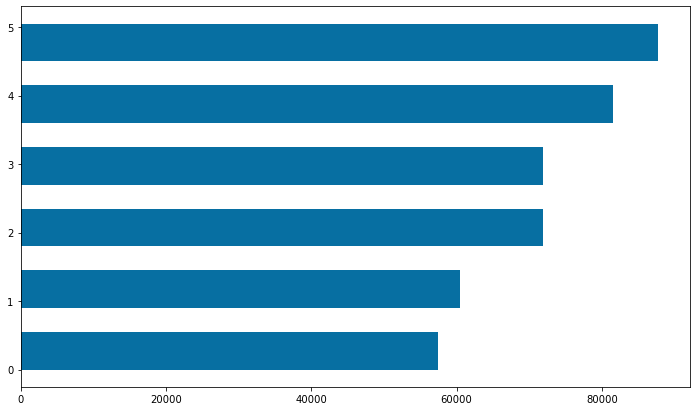

In [51]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(y, mse_values, height=0.55, align="edge", color=BLUE)

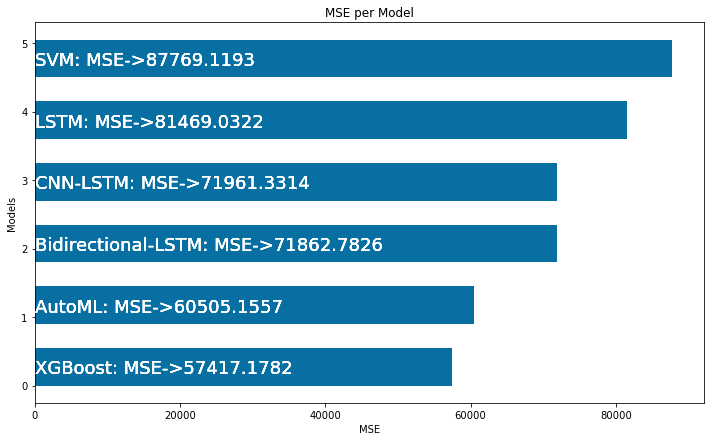

In [55]:
PAD = 0.3
for bar_color,name, count, y_pos in zip(RAINBOW ,model_names, mse_values, y):
    x = 0
    color = "white"
    path_effects = None
    if count < 8:
        x = count
        color = bar_color    
        path_effects=[withStroke(linewidth=6, foreground="white")]
    
    ax.text(
        x + PAD, y_pos + 0.5 / 2, name+ ': MSE->' +str(count), 
        color=color, fontfamily="Econ Sans Cnd", fontsize=18, va="center",
        path_effects=path_effects
    ) 

ax.set_xlabel('MSE')
ax.set_ylabel('Models')
ax.set_title("MSE per Model")
fig  